# **常规赛：中文新闻文本标题分类**

# 一.方案介绍

## 1.1 赛题简介：

文本分类是借助计算机对文本集(或其他实体或物件)按照一定的分类体系或标准进行自动分类标记。本次比赛为新闻标题文本分类 ，选手需要根据提供的新闻标题文本和类别标签训练一个新闻分类模型，然后对测试集的新闻标题文本进行分类，评价指标上使用Accuracy = 分类正确数量 / 需要分类总数量。同时本次参赛选手需使用飞桨框架和飞桨文本领域核心开发库PaddleNLP，PaddleNLP具备简洁易用的文本领域全流程API、多场景的应用示例、非常丰富的预训练模型，深度适配飞桨框架2.x版本。

比赛传送门：[常规赛：中文新闻文本标题分类](https://aistudio.baidu.com/aistudio/competition/detail/107)

## 1.2 数据介绍：

THUCNews是根据新浪新闻RSS订阅频道2005~2011年间的历史数据筛选过滤生成，包含74万篇新闻文档（2.19 GB），均为UTF-8纯文本格式。本次比赛数据集在原始新浪新闻分类体系的基础上，重新整合划分出14个候选分类类别：财经、彩票、房产、股票、家居、教育、科技、社会、时尚、时政、体育、星座、游戏、娱乐。提供训练数据共832471条。

比赛提供数据集的格式：训练集和验证集格式：原文标题+\t+标签，测试集格式：原文标题。

## 1.3 模型思路：

赛题是比较常规的短文本分类任务，在PaddleNLP框架下，首先通过微调9种预训练模型来训练与优化新闻标题14分类模型，然后通过集成学习（相对投票法、分值最大法等）融合不同模型的处理结果，最后分析结果文件生成伪标签，迭代扩充训练集规模。

由于预训练模型运行消耗的内存资源较多，所以运行时需要选择至尊版的GPU环境！若显存不足注意适当改小下batchsize！

BERT前置知识补充：[【原理】经典的预训练模型-BERT](https://aistudio.baidu.com/aistudio/projectdetail/2297740)

![](https://ai-studio-static-online.cdn.bcebos.com/adafc232c53f49258d410e68e3863f1de6747547a9d34ca6b6bf8f4891f4621b)

![](https://ai-studio-static-online.cdn.bcebos.com/b3c5b8ca36e84dcda5a9f1b35b1c6123caf703a1d5b34e1db841bcfdeac2d0d5)

# 二.数据读取与分析

In [2]:
# 进入比赛数据集存放目录
%cd /home/aistudio/dataset/

/home/aistudio/dataset


In [3]:
# 使用pandas读取数据集
import pandas as pd
train = pd.read_table('train.txt', sep='\t',header=None)  # 训练集
dev = pd.read_table('dev.txt', sep='\t',header=None)      # 验证集（官方已经划分的）
test = pd.read_table('test.txt', sep='\t',header=None)    # 测试集

In [5]:
# 对数据集手动添加列名
train.columns = ["text_a",'label']
dev.columns = ["text_a",'label']
test.columns = ["text_a"]

In [6]:
# 拼接训练和验证集，进行统计分析
total = pd.concat([train,dev],axis=0)
print(total.label.unique())
print(total.label.unique().tolist())

['科技' '体育' '时政' '股票' '娱乐' '教育' '家居' '财经' '房产' '社会' '游戏' '彩票' '星座' '时尚']
['科技', '体育', '时政', '股票', '娱乐', '教育', '家居', '财经', '房产', '社会', '游戏', '彩票', '星座', '时尚']


In [7]:
# 拼接训练和验证集，进行统计分析
total = pd.concat([train,dev],axis=0)
print("不同类别的标签数量和占比如下：")
# 得到不同类别的标签数量和占比，按照降序排列，数据类型是“pandas.core.series.Series”
series_Count_desc = total['label'].value_counts()
series_Ratio_desc = (train['label'].value_counts())/sum(train['label'].value_counts())
# 合并不同类别的标签数量和占比，仍然是降序排列
series_Info_desc = pd.concat([series_Count_desc,series_Ratio_desc],axis=1)
# print(series_Info_desc)
# print(series_Info_desc.keys())
# 定义要进行分类的类别
label_list = total.label.unique().tolist()
# 建立由分类标签到ID的映射表
Label_ID_map = {Val:ID for ID,Val in enumerate(label_list)}
series_Info_data = pd.Series(Label_ID_map)
# print(series_Info_data.keys())
# 按照ID的顺序，重新排列不同类别的标签数量和占比
df_Info_data = pd.concat([series_Info_data,series_Info_desc],axis=1)
# 设置列名称
df_Info_data.columns=['ID','Count','Ratio']
print(df_Info_data)
# print(type(df_Info_data))

不同类别的标签数量和占比如下：
    ID   Count     Ratio
科技   0  162245  0.194874
体育   1  130982  0.157401
时政   2   62867  0.075455
股票   3  153949  0.184670
娱乐   4   92228  0.110792
教育   5   41680  0.050159
家居   6   32363  0.038976
财经   7   36963  0.044372
房产   8   19922  0.023981
社会   9   50541  0.060820
游戏  10   24283  0.029152
彩票  11    7598  0.009077
星座  12    3515  0.004281
时尚  13   13335  0.015990


In [8]:
#计算损失函数不同类型的权重：占有比例的倒数，需要进行归一化
series_Recip_desc = 1/series_Ratio_desc#倒数
series_Weight_desc = series_Recip_desc
series_WeightNorm_desc = series_Recip_desc/sum(series_Recip_desc)#归一化
# print(series_Recip_desc)
# print(series_Weight_desc)
#合并到不同类别的标签数量和占比种
df_Info_data = pd.concat([df_Info_data,series_Weight_desc],axis=1)
df_Info_data = pd.concat([df_Info_data,series_WeightNorm_desc],axis=1)
# 设置列名称
df_Info_data.columns=['ID','Count','Ratio','Weight','Weight Norm']
print(df_Info_data)

    ID   Count     Ratio      Weight  Weight Norm
科技   0  162245  0.194874    5.131522     0.008467
体育   1  130982  0.157401    6.353183     0.010482
时政   2   62867  0.075455   13.252862     0.021867
股票   3  153949  0.184670    5.415058     0.008935
娱乐   4   92228  0.110792    9.025897     0.014892
教育   5   41680  0.050159   19.936703     0.032895
家居   6   32363  0.038976   25.657085     0.042333
财经   7   36963  0.044372   22.536494     0.037184
房产   8   19922  0.023981   41.699695     0.068802
社会   9   50541  0.060820   16.442063     0.027129
游戏  10   24283  0.029152   34.303018     0.056598
彩票  11    7598  0.009077  110.171449     0.181778
星座  12    3515  0.004281  233.614095     0.385452
时尚  13   13335  0.015990   62.539146     0.103187


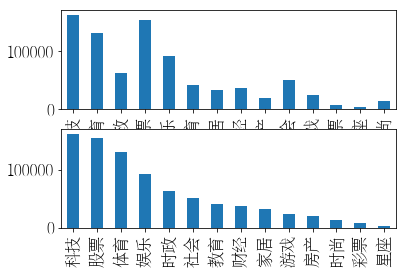

In [9]:
# 全局设置解决matplotlib中文显示错误的问题，参考：https://aistudio.baidu.com/aistudio/projectdetail/1658980
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

# 设置显示中文
matplotlib.rcParams['font.sans-serif'] = ['FZSongYi-Z13S'] # 指定默认字体
matplotlib.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
# 设置字体大小
matplotlib.rcParams['font.size'] = 16

# 绘制不同类型标签的分布情况(按照ID升序排列)
plt.subplot2grid((2,2),(0,0),colspan=2)
df_Info_data['Count'].plot(kind='bar');
# 绘制不同类型标签的分布情况(按照样本数量降序排列)
plt.subplot2grid((2,2),(1,0),colspan=2)
series_Count_desc.plot(kind='bar');

In [12]:
# 统计“训练集+验证集”的长度信息
print("The length information of Train&&Dev is as follows:/n")
print(total['text_a'].map(len).describe())
# 统计“测试集”的长度信息
print("The length information of Test is as follows:/n")
print(test['text_a'].map(len).describe())

The length information of Train&&Dev is as follows:/n
count    832471.000000
mean         19.388112
std           4.097139
min           2.000000
25%          17.000000
50%          20.000000
75%          23.000000
max          48.000000
Name: text_a, dtype: float64
The length information of Test is as follows:/n
count    83599.000000
mean        19.815022
std          3.883845
min          3.000000
25%         17.000000
50%         20.000000
75%         23.000000
max         84.000000
Name: text_a, dtype: float64


In [11]:
# 是否使用全部数据集（训练集+验证集）进行训练
useTotalData = False
# 是否使用伪标签进行训练
useFakeData = False
# 是否仅使用伪标签进行训练（增量学习）
useFakeOnly = False
if useTotalData == True:
    #使用全部数据集（训练集+验证集）进行训练
    train = pd.concat([train,dev],axis=0)
if useFakeData == True:
    #使用伪标签进行训练
    train = pd.concat([train,fakeData1],axis=0)
if useFakeOnly == True:
    #仅使用伪标签进行训练（增量学习）
    train = fakeData1
# 保存处理后的数据集文件
train.to_csv('train.csv', sep='\t', index=False)  # 保存训练集，格式为text_a,label，以\t分隔开
dev.to_csv('dev.csv', sep='\t', index=False)      # 保存验证集，格式为text_a,label，以\t分隔开
test.to_csv('test.csv', sep='\t', index=False)    # 保存测试集，格式为text_a，以\t分隔开

# 三.构建基于PaddleNLP的基线模型

![](https://ai-studio-static-online.cdn.bcebos.com/75742955d912447c948bb679994a09039af5f85cfb554715be56c970db5ec3f6)

## 3.1 设置运行环境

In [ ]:
# 导入所需的第三方库
import math
import numpy as np
import os
import collections
from functools import partial
import random
import time
import inspect
import importlib
from tqdm import tqdm
import paddle
import paddle.nn as nn
import paddle.nn.functional as F
from paddle.io import IterableDataset
from paddle.utils.download import get_path_from_url

In [ ]:
# 下载paddlenlp2.1，最新版本是2.2，在后面的步骤会出现问题
!pip install --upgrade paddlenlp==2.1

# 导入paddlenlp所需的相关包
import paddlenlp as ppnlp
from paddlenlp.data import JiebaTokenizer, Pad, Stack, Tuple, Vocab
from paddlenlp.datasets import MapDataset
from paddle.dataset.common import md5file
from paddlenlp.datasets import DatasetBuilder

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Requirement already up-to-date: paddlenlp==2.1 in /opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages (2.1.0)


## 3.2 定义要进行微调的预训练模型

在预训练模型选择上，选择了不同的7个中文领域效果较优的预训练模型，采用训练集进行训练后，提交分值如下：

roberta-wwm-ext-large：89.08

nezha-large-wwm-chinese：88.96

skep_ernie_1.0_large_ch：88.82

bert-wwm-ext-chinese：88.62

macbert-large-chinese：88.75

huhuiwen/mengzi-bert-base：88.64

junnyu/hfl-chinese-electra-180g-base-discriminator：88.28

In [ ]:
# 使用roberta-wwm-ext-large模型
MODEL_NAME = "roberta-wwm-ext-large"
# 只需指定想要使用的模型名称和文本分类的类别数即可完成Fine-tune网络定义，通过在预训练模型后拼接上一个全连接网络（Full Connected）进行分类
model = ppnlp.transformers.RobertaForSequenceClassification.from_pretrained(MODEL_NAME, num_classes=14) # 此次分类任务为14分类任务，故num_classes设置为14
# 定义模型对应的tokenizer，tokenizer可以把原始输入文本转化成模型model可接受的输入数据格式。需注意tokenizer类要与选择的模型相对应，具体可以查看PaddleNLP相关文档
tokenizer = ppnlp.transformers.RobertaTokenizer.from_pretrained(MODEL_NAME)

[2022-01-20 11:12:00,457] [    INFO] - Already cached /home/aistudio/.paddlenlp/models/roberta-wwm-ext-large/roberta_chn_large.pdparams
[2022-01-20 11:12:05,655] [    INFO] - Already cached /home/aistudio/.paddlenlp/models/roberta-wwm-ext-large/vocab.txt


In [ ]:
# 使用nezha-large-wwm-chinese模型
# 指定模型名称，一键加载模型
#model = ppnlp.transformers.NeZhaForSequenceClassification.from_pretrained('nezha-large-wwm-chinese', num_classes=14)
# 同样地，通过指定模型名称一键加载对应的Tokenizer，用于处理文本数据，如切分token，转token_id等
#tokenizer = ppnlp.transformers.NeZhaTokenizer.from_pretrained('nezha-large-wwm-chinese')

In [ ]:
# skep_ernie_1.0_large_ch模型
# 指定模型名称，一键加载模型
#model = ppnlp.transformers.SkepForSequenceClassification.from_pretrained(pretrained_model_name_or_path="skep_ernie_1.0_large_ch", num_classes=14)
# 同样地，通过指定模型名称一键加载对应的Tokenizer，用于处理文本数据，如切分token，转token_id等
#tokenizer = ppnlp.transformers.SkepTokenizer.from_pretrained(pretrained_model_name_or_path="skep_ernie_1.0_large_ch")

In [ ]:
# 使用bert-wwm-ext-chinese模型
MODEL_NAME = "bert-wwm-ext-chinese"
# 只需指定想要使用的模型名称和文本分类的类别数即可完成Fine-tune网络定义，通过在预训练模型后拼接上一个全连接网络（Full Connected）进行分类
model = ppnlp.transformers.BertForSequenceClassification.from_pretrained(MODEL_NAME, num_classes=14) # 此次分类任务为14分类任务，故num_classes设置为14
# 定义模型对应的tokenizer，tokenizer可以把原始输入文本转化成模型model可接受的输入数据格式。需注意tokenizer类要与选择的模型相对应，具体可以查看PaddleNLP相关文档
tokenizer = ppnlp.transformers.BertTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
# 使用macbert-large-chinese模型
#MODEL_NAME = "macbert-large-chinese"
# 只需指定想要使用的模型名称和文本分类的类别数即可完成Fine-tune网络定义，通过在预训练模型后拼接上一个全连接网络（Full Connected）进行分类
#model = ppnlp.transformers.BertForSequenceClassification.from_pretrained(MODEL_NAME, num_classes=14) # 此次分类任务为14分类任务，故num_classes设置为14
# 定义模型对应的tokenizer，tokenizer可以把原始输入文本转化成模型model可接受的输入数据格式。需注意tokenizer类要与选择的模型相对应，具体可以查看PaddleNLP相关文档
#tokenizer = ppnlp.transformers.BertTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
# 使用huhuiwen/mengzi-bert-base模型
#MODEL_NAME = "huhuiwen/mengzi-bert-base"
# 只需指定想要使用的模型名称和文本分类的类别数即可完成Fine-tune网络定义，通过在预训练模型后拼接上一个全连接网络（Full Connected）进行分类
#model = ppnlp.transformers.BertForSequenceClassification.from_pretrained(MODEL_NAME, num_classes=14) # 此次分类任务为14分类任务，故num_classes设置为14
# 定义模型对应的tokenizer，tokenizer可以把原始输入文本转化成模型model可接受的输入数据格式。需注意tokenizer类要与选择的模型相对应，具体可以查看PaddleNLP相关文档
#tokenizer = ppnlp.transformers.BertTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
# 使用junnyu/hfl-chinese-electra-180g-base-discriminator模型
# 指定模型名称，一键加载模型
#model = ppnlp.transformers.ElectraForSequenceClassification.from_pretrained('junnyu/hfl-chinese-electra-180g-base-discriminator', num_classes=14)
# 同样地，通过指定模型名称一键加载对应的Tokenizer，用于处理文本数据，如切分token，转token_id等
#tokenizer = ppnlp.transformers.ElectraTokenizer.from_pretrained('junnyu/hfl-chinese-electra-180g-base-discriminator')

PaddleNLP不仅支持RoBERTa预训练模型，还支持ERNIE、BERT、Electra等预训练模型。具体可以查看：[PaddleNLP模型](https://paddlenlp.readthedocs.io/zh/latest/source/paddlenlp.transformers.html)

下表汇总了目前PaddleNLP支持的各类预训练模型。用户可以使用PaddleNLP提供的模型，完成问答、序列分类、token分类等任务。同时还提供了22种预训练的参数权重供用户使用，其中包含了11种中文语言模型的预训练权重。

| Model | Tokenizer| Supported Task| Model Name|
|---|---|---|---|
| [BERT](https://arxiv.org/abs/1810.04805) | BertTokenizer|BertModel<br> BertForQuestionAnswering<br> BertForSequenceClassification<br>BertForTokenClassification| `bert-base-uncased`<br> `bert-large-uncased` <br>`bert-base-multilingual-uncased` <br>`bert-base-cased`<br> `bert-base-chinese`<br> `bert-base-multilingual-cased`<br> `bert-large-cased`<br> `bert-wwm-chinese`<br> `bert-wwm-ext-chinese` |
|[ERNIE](https://arxiv.org/abs/1904.09223)|ErnieTokenizer<br>ErnieTinyTokenizer|ErnieModel<br> ErnieForQuestionAnswering<br> ErnieForSequenceClassification<br> ErnieForTokenClassification| `ernie-1.0`<br> `ernie-tiny`<br> `ernie-2.0-en`<br> `ernie-2.0-large-en`|
|[RoBERTa](https://arxiv.org/abs/1907.11692)|RobertaTokenizer| RobertaModel<br>RobertaForQuestionAnswering<br>RobertaForSequenceClassification<br>RobertaForTokenClassification| `roberta-wwm-ext`<br> `roberta-wwm-ext-large`<br> `rbt3`<br> `rbtl3`|
|[ELECTRA](https://arxiv.org/abs/2003.10555) |ElectraTokenizer| ElectraModel<br>ElectraForSequenceClassification<br>ElectraForTokenClassification<br>|`electra-small`<br> `electra-base`<br> `electra-large`<br> `chinese-electra-small`<br> `chinese-electra-base`<br>|

注：其中中文的预训练模型有 `bert-base-chinese, bert-wwm-chinese, bert-wwm-ext-chinese, ernie-1.0, ernie-tiny, roberta-wwm-ext, roberta-wwm-ext-large, rbt3, rbtl3, chinese-electra-base, chinese-electra-small` 等。

## 3.3 数据读取和处理

In [ ]:
# 定义数据集对应文件及其文件存储格式
class NewsData(DatasetBuilder):
    #训练集和验证集对应文件名称
    SPLITS = {
        'train': 'train.csv',  # 训练集
        'dev': 'dev.csv',      # 验证集
    }

    #获取训练集和验证集的文件名称
    def _get_data(self, mode, **kwargs):
        filename = self.SPLITS[mode]
        return filename

    #从文件中读取数据
    def _read(self, filename):
        with open(filename, 'r', encoding='utf-8') as f:
            head = None
            for line in f:
                data = line.strip().split("\t")    # 以'\t'分隔各列
                if not head:
                    head = data
                else:
                    text_a, label = data
                    yield {"text_a": text_a, "label": label}  # 此次设置数据的格式为：text_a,label，可以根据具体情况进行修改

    #获取类别标签
    def get_labels(self):
        return label_list   # 类别标签

In [ ]:
# 定义数据集加载函数
def load_dataset(name=None,
                 data_files=None,
                 splits=None,
                 lazy=None,
                 **kwargs):
   
    reader_cls = NewsData  # 加载定义的数据集格式
    print(reader_cls)
    #数据集加载实例
    if not name:
        reader_instance = reader_cls(lazy=lazy, **kwargs)
    else:
        reader_instance = reader_cls(lazy=lazy, name=name, **kwargs)
    
    #通过实例加载数据集
    datasets = reader_instance.read_datasets(data_files=data_files, splits=splits)
    return datasets

In [ ]:
# 加载训练和验证集
train_ds, dev_ds = load_dataset(splits=["train", "dev"])

<class '__main__.NewsData'>


In [ ]:
# 定义数据加载和处理函数
def convert_example(example, tokenizer, max_seq_length=128, is_test=False):
    qtconcat = example["text_a"]
    encoded_inputs = tokenizer(text=qtconcat, max_seq_len=max_seq_length)  # tokenizer处理为模型可接受的格式 
    input_ids = encoded_inputs["input_ids"]
    token_type_ids = encoded_inputs["token_type_ids"]

    #如果不是测试集，则需要返回标签
    if not is_test:
        label = np.array([example["label"]], dtype="int64")
        return input_ids, token_type_ids, label
    else:#测试集不需要返回标签
        return input_ids, token_type_ids

# 定义数据加载函数dataloader
def create_dataloader(dataset,
                      mode='train',
                      batch_size=1,
                      batchify_fn=None,
                      trans_fn=None):
    if trans_fn:
        dataset = dataset.map(trans_fn)

    shuffle = True if mode == 'train' else False
    # 训练数据集随机打乱，测试数据集不打乱
    if mode == 'train':
        batch_sampler = paddle.io.DistributedBatchSampler(
            dataset, batch_size=batch_size, shuffle=shuffle)
    else:
        batch_sampler = paddle.io.BatchSampler(
            dataset, batch_size=batch_size, shuffle=shuffle)

    return paddle.io.DataLoader(
        dataset=dataset,
        batch_sampler=batch_sampler,
        collate_fn=batchify_fn,
        return_list=True)

In [ ]:
# 参数设置：
# 批处理大小，显存如若不足的话可以适当改小该值
# 注意该场景下若使用nezha-large-wwm-chinese需将batch_size修改为256，chinese-xlnet-large修改为128，其他模型则为300。否则容易出现爆显存问题
batch_size = 256
# 文本序列最大截断长度，需要根据文本具体长度进行确定，最长不超过512。 通过文本长度分析可以看出文本长度最大为48，故此处设置为48
max_seq_length = 48

In [ ]:
# 将数据处理成模型可读入的数据格式
trans_func = partial(
    convert_example,
    tokenizer=tokenizer,
    max_seq_length=max_seq_length)

batchify_fn = lambda samples, fn=Tuple(
    Pad(axis=0, pad_val=tokenizer.pad_token_id),  # input_ids
    Pad(axis=0, pad_val=tokenizer.pad_token_type_id),  # token_type_ids
    Stack()  # labels
): [data for data in fn(samples)]

# 训练集迭代器
train_data_loader = create_dataloader(
    train_ds,
    mode='train',
    batch_size=batch_size,
    batchify_fn=batchify_fn,
    trans_fn=trans_func)

# 验证集迭代器
dev_data_loader = create_dataloader(
    dev_ds,
    mode='dev',
    batch_size=batch_size,
    batchify_fn=batchify_fn,
    trans_fn=trans_func)

## 3.4 设置Fine-Tune优化策略，接入评价指标

数据分布不均衡，采用Focal Loss计算损失函数。
为了避免模型不稳定（振荡），采用以较低学习率逐渐增大至较高学习率的方式实现网络训练的“热身”策略（WarmUp），如下：
![](https://ai-studio-static-online.cdn.bcebos.com/96164785831147b382bfc8d54161ec8794571c1528b34fa4b126e6d3d109be3d)

In [ ]:
#按照Focal Loss损失函数定义计算，发现效果不如Paddle的交叉熵
import paddle.nn.functional as F
class MultiCEFocalLoss(nn.Layer):
    #class_num：类型数量，reduction：如何处理不同类型的损失函数贡献，可以选择：平均值(mean)、总和(sum)，默认mean。
    #use_softmax：是否对输入数据进行softmax处理
    def __init__(self, class_num, gamma=2, alpha=None, reduction='mean',use_softmax=True):
        super(MultiCEFocalLoss, self).__init__()
        if alpha is None:
            self.alpha = paddle.ones((class_num, 1))
        elif isinstance(alpha,list):
            self.alpha = paddle.to_tensor(alpha,dtype=paddle.float32)
        elif isinstance(alpha,[float,int]):
            self.alpha = paddle.to_tensor([alpha])
  
        self.gamma = gamma
        self.reduction = reduction
        self.class_num =  class_num
        self.use_softmax = use_softmax

    def forward(self, preds, labels):
        #print("predict",preds)
        #print("label",labels)
        labels = labels.cast(paddle.int64)
        # print("The dimension of preds is:",preds.ndim)
        # print("The dimension of labels is:",labels.ndim)
        if labels.ndim > 1:#去除labels中单值数组的维度
            labels = labels.squeeze(1)
        #样本中每个类型预测值构成的List
        if self.use_softmax:#基于softmmax的预测概率
            pt = F.softmax(preds,axis=-1)
        else:
            pt = preds
        # print("Processed predict",pt)
        #样本标签的One Hot编码
        class_mask = F.one_hot(labels, self.class_num)
        # print("One hot of each Label ID",class_mask)
        #转换为1列，元素为样本标签的ID
        ids = labels.reshape((-1, 1))
        # print("Label's ID",ids)
        # print("Label's alpha",self.alpha)
        #样本标签类型对应权重构成的List，长度等于样本个数
        alpha = self.alpha[ids.reshape((-1,1))].reshape((-1,1))
        # print("Label's alpha of each sample",alpha)
        #样本标签类型对应预测值(来自pt)构成的List，长度等于样本个数
        probs = (pt * class_mask).sum(1).reshape((-1, 1)) # 利用onehot作为mask，提取对应的pt
        # print("Label's predict of each sample",probs)
        log_p = probs.log()
        # print("Label's log predict of each sample",log_p)
        #融合样本标签类型的权重alpha、预测值对数log_p、动态衰减因子pow[(1-预测值), gama]，计算损失函数
        loss = -alpha * (paddle.pow((1 - probs), self.gamma)) * log_p
        # print(loss)
        
        #融合不同类型的损失函数贡献
        if self.reduction == 'mean':#平均值
            loss = loss.mean()
        elif self.reduction == 'sum':#总和
            loss = loss.sum()
        return loss

In [ ]:
# 定义超参，loss，优化器等
from paddlenlp.transformers import LinearDecayWithWarmup, CosineDecayWithWarmup

# 定义训练配置参数：
# 定义训练过程中的最大学习率
learning_rate = 4e-5
# 训练轮次
epochs = 4
# 学习率预热比例，用于控制“学习率-Step次数”曲线中峰值点的Step位置，此处是在整个Step的10%位置到达峰值，然后衰减。
warmup_proportion = 0.1
# 逐层权重衰减系数，类似模型正则项策略，避免模型过拟合
weight_decay = 0.0

#训练过程中总共经历的Step数量
num_training_steps = len(train_data_loader) * epochs
print(num_training_steps)
#线性预热学习率，在开始的“warmup_proportion*num_training_steps”个Step中，学习率由0线性增加到learning_rate，然后再余弦衰减到0。
lr_scheduler = CosineDecayWithWarmup(learning_rate, num_training_steps, warmup_proportion)

# AdamW优化器
optimizer = paddle.optimizer.AdamW(
    learning_rate=lr_scheduler,
    parameters=model.parameters(),
    weight_decay=weight_decay,
    apply_decay_param_fun=lambda x: x in [
        p.name for n, p in model.named_parameters()
        if not any(nd in n for nd in ["bias", "norm"])
    ])

#自定义Focal Loss函数
#criterion = MultiCEFocalLoss(class_num=14, alpha=(df_Info_data['Weight'].values.tolist()))
#交叉熵损失函数
criterion = paddle.nn.CrossEntropyLoss(weight=paddle.to_tensor(df_Info_data['Weight'].values.astype("float32")))
#criterion = paddle.nn.CrossEntropyLoss()
metric = paddle.metric.Accuracy()              # accuracy评价指标

11760


## 3.5 模型训练与评估
ps：模型训练时，通过观察损失函数、准确率等参数的变化情况，判断训练参数是否合适、是否产生过拟合。
通过在终端输入nvidia-smi命令或者通过点击底部‘性能监控’选项查看显存的占用情况，适当调整好batchsize，防止显存不足导致暂停。

In [ ]:
# 定义模型训练验证评估函数
@paddle.no_grad()
def evaluate(model, criterion, metric, data_loader):
    model.eval()
    metric.reset()
    losses = []
    for batch in data_loader:
        input_ids, token_type_ids, labels = batch
        logits = model(input_ids, token_type_ids)
        loss = criterion(logits, labels)
        losses.append(loss.numpy())
        correct = metric.compute(logits, labels)
        metric.update(correct)
        accu = metric.accumulate()
    print("eval loss: %.5f, accu: %.5f" % (np.mean(losses), accu))  # 输出验证集上评估效果
    model.train()
    metric.reset()
    return accu  # 返回准确率

In [ ]:
# 固定随机种子便于结果的复现
seed = 1024
random.seed(seed)
np.random.seed(seed)
paddle.seed(seed)

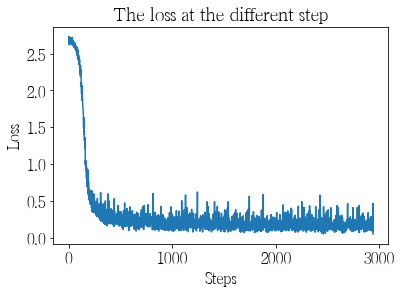

<Figure size 432x288 with 0 Axes>

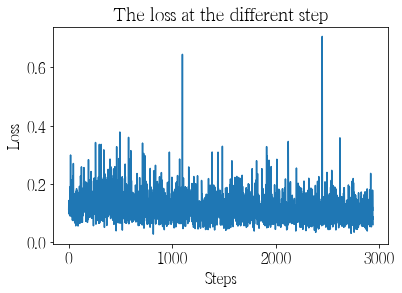

<Figure size 432x288 with 0 Axes>

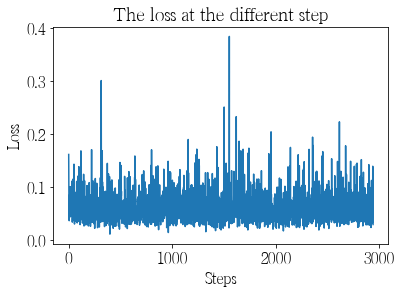

<Figure size 432x288 with 0 Axes>

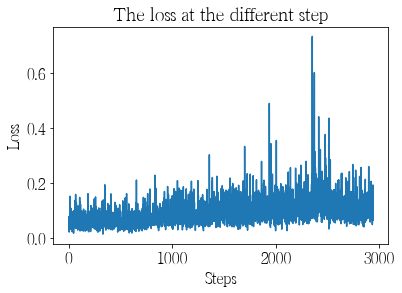

<Figure size 432x288 with 0 Axes>

In [ ]:
# 模型训练：
import paddle.nn.functional as F
import matplotlib.pyplot as plt

#验证集上准确率最高模型的保存路径
save_dir = "checkpoint"
if not  os.path.exists(save_dir):
    os.makedirs(save_dir)

#最后1个Epoch结束后模型的保存路径
save_final_dir = "checkpoint_final"
if not  os.path.exists(save_final_dir):
    os.makedirs(save_final_dir)

pre_accu=0
accu=0
global_step = 0
#记录效果更优时的Step和Epoch数值
best_global_step = 0
best_epoch = 0
#逐个Epoch进行处理
for epoch in range(1, epochs + 1):
    losses = []
    #逐个Step进行处理
    for step, batch in enumerate(train_data_loader, start=1):
        input_ids, segment_ids, labels = batch
        logits = model(input_ids, segment_ids)
        # print(len(logits[0]))
        # print(len(labels[0]))
        # print(logits)
        # print(labels)
        loss = criterion(logits, labels)
        losses.append(loss.numpy())
        probs = F.softmax(logits, axis=1)
        correct = metric.compute(probs, labels)
        metric.update(correct)
        acc = metric.accumulate()

        global_step += 1
        #每隔10个Step，统计结果并输出
        if global_step % 10 == 0:
            print("global step %d, epoch: %d, batch: %d, loss: %.5f, avgLoss: %.5f, acc: %.5f" % (global_step, epoch, step, loss, np.mean(losses), acc))
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.clear_grad()

        if useTotalData == False:
            #没有使用全部数据集（训练集+验证集）进行训练，则每隔一定的批次数后进行评估，避免遗漏中间的最佳模型
            if global_step % 300 == 0:
                accu = evaluate(model, criterion, metric, dev_data_loader)
                if accu > pre_accu:
                    # 保存效果更优的模型参数
                    save_param_path = os.path.join(save_dir, 'model_state.pdparams')  # 保存模型参数
                    paddle.save(model.state_dict(), save_param_path)
                    pre_accu=accu
                    #记录效果更优时的Step和Epoch数值
                    best_global_step = global_step
                    best_epoch = epoch
                    print("The best model is found in epoch: %d, batch: %d" % (best_epoch, best_global_step))
    
    if useTotalData == False:
        #没有使用全部数据集（训练集+验证集）进行训练，则每轮结束对验证集进行评估
        accu = evaluate(model, criterion, metric, dev_data_loader)
        print(accu)
        if accu > pre_accu:
            #保存较上一轮效果更优的模型参数
            save_param_path = os.path.join(save_dir, 'model_state.pdparams')
            paddle.save(model.state_dict(), save_param_path)
            pre_accu=accu
            #记录效果更优时的Step和Epoch数值
            best_global_step = global_step
            best_epoch = epoch
        print("The best model is found in epoch: %d, batch: %d" % (best_epoch, best_global_step))
    else:#保存本轮的模型参数，避免中间宕机
        save_param_path = os.path.join(save_dir, 'model_state.pdparams')
        paddle.save(model.state_dict(), save_param_path)
    tokenizer.save_pretrained(save_dir)

    #绘制损失函数曲线
    plt.figure()
    #曲线标题
    plt.title("The loss at the different step")
    #曲线X轴和Y轴名称
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.plot(losses)
    plt.figure()

#最后1个Epoch结束后，保存模型
save_final_param_path = os.path.join(save_final_dir, 'model_state.pdparams')
paddle.save(model.state_dict(), save_final_param_path)
tokenizer.save_pretrained(save_final_dir)

In [ ]:
# 加载在验证集上效果最优的一轮的模型参数
import os
import paddle

params_path = 'checkpoint_final/model_state.pdparams'
if params_path and os.path.isfile(params_path):
    # 加载模型参数
    state_dict = paddle.load(params_path)
    model.set_dict(state_dict)
    print("Loaded parameters from %s" % params_path)

Loaded parameters from checkpoint_final/model_state.pdparams


In [ ]:
# 测试最优模型参数在验证集上的分数
evaluate(model, criterion, metric, dev_data_loader)

eval loss: 0.06091, accu: 0.96970


0.9697

## 3.6 模型预测

In [ ]:
# 定义要进行分类的类别
label_list = train.label.unique().tolist()
label_map = { 
    idx: label_text for idx, label_text in enumerate(label_list)
}
print(label_map)

{0: '科技', 1: '体育', 2: '时政', 3: '股票', 4: '娱乐', 5: '教育', 6: '家居', 7: '财经', 8: '房产', 9: '社会', 10: '游戏', 11: '彩票', 12: '星座', 13: '时尚'}


In [ ]:
# 定义模型预测函数
def predict(model, data, tokenizer, label_map, batch_size=1):
    examples = []
    # 将输入数据（list格式）处理为模型可接受的格式
    for text in data:
        input_ids, segment_ids = convert_example(
            text,
            tokenizer,
            max_seq_length=128,
            is_test=True)
        examples.append((input_ids, segment_ids))

    batchify_fn = lambda samples, fn=Tuple(
        Pad(axis=0, pad_val=tokenizer.pad_token_id),  # input id
        Pad(axis=0, pad_val=tokenizer.pad_token_id),  # segment id
    ): fn(samples)

    # 将数据集分割为多个批次(Batch)，保存在batches中
    batches = []
    one_batch = []
    #逐个处理样本
    for example in examples:
        #将每个样本添加到one_batch中，如果个数增加到batch size，那么做为1个批次添加到batches中
        one_batch.append(example)
        if len(one_batch) == batch_size:
            batches.append(one_batch)
            one_batch = []
    if one_batch:
        #处理最后1个one_batch的元素个数小于batch size的特殊情况
        batches.append(one_batch)

    results = []
    model.eval()
    #逐批次处理数据
    for batch in batches:
        input_ids, segment_ids = batchify_fn(batch)
        input_ids = paddle.to_tensor(input_ids)
        segment_ids = paddle.to_tensor(segment_ids)
        logits = model(input_ids, segment_ids)
        probs = F.softmax(logits, axis=1)
        idx = paddle.argmax(probs, axis=1).numpy()
        idx = idx.tolist()
        labels = [label_map[i] for i in idx]
        results.extend(labels)
    return results  # 返回预测结果

# 定义对数据的预处理函数,处理为模型输入指定list格式
def preprocess_prediction_data(data):
    examples = []
    for text_a in data:
        examples.append({"text_a": text_a})
    return examples

# 将list格式的预测结果存储为txt文件，提交格式要求：每行一个类别
def write_results(labels, file_path):
    with open(file_path, "w", encoding="utf8") as f:
        f.writelines("\n".join(labels))

In [ ]:
# 读取要进行预测的测试集文件
test = pd.read_csv('./test.csv',sep='\t')

# 对测试集数据进行格式处理
test_data = list(test.text_a)
test_example = preprocess_prediction_data(test_data)

In [ ]:
# 对测试集进行预测
results = predict(model, test_example, tokenizer, label_map, batch_size=16) 

In [ ]:
#保存预测结果为符合格式要求的txt文件
write_results(results, "./result.txt")
#压缩为zip文件
!zip 'submission.zip' 'result.txt'
!cp -r submission.zip /home/aistudio/

# 四.集成学习
采用投票法，将多个模型的结果融合为单个结果，消除不一致性

按照等权重融合7个模型的结果，提交结果的分值：0.89494

采用权重158、146、132、112、125、114、78融合7个模型的结果，提交结果的分值：0.89527

In [17]:
#计算结果相关性时，label列只能是ID，所以需要把原先的name转换为ID
#建立由分类标签到ID的映射表
label_ID_map = {Val:ID for ID,Val in enumerate(label_list)}
print(label_ID_map)

{'科技': 0, '体育': 1, '时政': 2, '股票': 3, '娱乐': 4, '教育': 5, '家居': 6, '财经': 7, '房产': 8, '社会': 9, '游戏': 10, '彩票': 11, '星座': 12, '时尚': 13}


In [18]:
#由于预测结果文件每行只有label，需要进行预处理，生成若干文件
#predfile: 保存模型预测结果生成的文件，仅有label列
#label_ID_map：由分类标签到ID的映射表，weight：结果文件的权重
#resultfile：将predfile添加列（'id','label'）后的结果文件
#resultIDfile：将resultfile的分类标签转换为ID后的结果文件
def preprocess_prediction_file(predfile, label_ID_map, weight, resultfile, resultIDfile):
    dftab = pd.read_table(predfile,header=None)
    dftab.columns = ['label']
    #为数据添加id索引
    lst_ID = []
    for i in range(1,len(dftab) + 1):
        lst_ID.append(i)
    id = pd.DataFrame(lst_ID)
    dftab['id'] = id
    
    #由ID和Label构成的DataFrame
    dftab = dftab[['id','label']]
    #保存结果
    dftab.to_csv(resultfile, index=False)
    #名称带有权重的结果文件
    resultWeightfile = "_w" + str(int(weight)) + "_" + resultfile
    dftab.to_csv(resultWeightfile, index=False)

    #为数据添加标签ID
    lst_LabelID = []
    for i in range(1,len(dftab) + 1):
        lst_LabelID.append(label_ID_map[dftab['label'][i-1]])
    labelID = pd.DataFrame(lst_LabelID)
    dftab['labelID'] = labelID

    #由ID和LabelID构成的DataFrame
    dfIDtab = dftab[['id','labelID']]
    #保存结果
    dfIDtab.to_csv(resultIDfile, index=False)

In [22]:
%cd /home/aistudio/merge_result/
#清除已有的csv文件
!rm *.csv

/home/aistudio/merge_result
rm: cannot remove '*.csv': No such file or directory


In [23]:
#对模型预测结果文件进行预处理
preprocess_prediction_file("./result89.08.txt", label_ID_map, 158, "method1.csv", "method1_ID.csv")
preprocess_prediction_file("./result88.96.txt", label_ID_map, 146, "method2.csv", "method2_ID.csv")
preprocess_prediction_file("./result88.82.txt", label_ID_map, 132, "method3.csv", "method3_ID.csv")
preprocess_prediction_file("./result88.62.txt", label_ID_map, 112, "method4.csv", "method4_ID.csv")
preprocess_prediction_file("./result88.75.txt", label_ID_map, 125, "method5.csv", "method5_ID.csv")
preprocess_prediction_file("./result88.64.txt", label_ID_map, 114, "method6.csv", "method6_ID.csv")
preprocess_prediction_file("./result88.28.txt", label_ID_map, 78, "method7.csv", "method7_ID.csv")

In [25]:
# 计算结果的相关性
!python correlations.py "./method1_ID.csv" "./method2_ID.csv"

Finding correlation between: ./method1_ID.csv and ./method2_ID.csv
Column to be measured: labelID
Pearson's correlation score: 0.9269307860693886
Kendall's correlation score: 0.9219420409220379
Spearman's correlation score: 0.9367103330656568


In [26]:
# 等权重投票融合
!python kaggle_vote.py "./method?.csv" "./merge.csv"
# 加权投票融合
!python kaggle_vote.py "./_w*.csv" "./merge_weight.csv" "weighted"

parsing: ./method3.csv
parsing: ./method2.csv
parsing: ./method1.csv
parsing: ./method5.csv
parsing: ./method7.csv
parsing: ./method4.csv
parsing: ./method6.csv
wrote to ./merge.csv
parsing: ./_w78_method7.csv
Using weight: 78
parsing: ./_w146_method2.csv
Using weight: 146
parsing: ./_w112_method4.csv
Using weight: 112
parsing: ./_w158_method1.csv
Using weight: 158
parsing: ./_w125_method5.csv
Using weight: 125
parsing: ./_w132_method3.csv
Using weight: 132
parsing: ./_w114_method6.csv
Using weight: 114
wrote to ./merge_weight.csv


In [27]:
# 由于融合产生的结果不符合格式要求故还需要进行下简单的格式处理
# df1 = pd.read_csv('./_w4_method1.csv')
# df2 = pd.read_csv('./merge_weight.csv')
df1 = pd.read_csv('./method1.csv')
df2 = pd.read_csv('./merge.csv')
# 将筛选出来的填充到新的表上，主要解决id乱序了的问题
df1['label'] = df1['id'].map(df2.set_index('id')['label'])
df1 = df1['label']
# 保存预测结果文件
df1.to_csv('result.txt',index=False,header=None)
# 将结果文件压缩为zip文件
!zip 'result.zip' 'result.txt'

  adding: result.txt (deflated 89%)


# 五.直推学习
采用直推学习，将高质量测试集转换为训练集，提高有效样本数量

根据直推学习生成的伪标签，通过两次训练，提交结果分值为：90.01和90.06447。

In [28]:
#由于预测结果文件每行只有label，需要添加ID索引
#predfile: 保存模型预测结果生成的文件，仅有label列
#resultfile：将predfile添加列（'id','label'）后的结果文件
def addIDIndex_prediction_file(predfile, resultfile):
    dftab = pd.read_table(predfile,header=None)
    dftab.columns = ['label']
    #为数据添加id索引
    lst_ID = []
    for i in range(1,len(dftab) + 1):
        lst_ID.append(i)
    id = pd.DataFrame(lst_ID)
    dftab['id'] = id
    
    #由ID和Label构成的DataFrame
    dftab = dftab[['id','label']]
    #保存结果
    dftab.to_csv(resultfile, index=False)

In [29]:
#将由列（'id','label'）构成的文件转换为KV表（'id'：'label'）
def iDLabelFile2KVTable(iDLabelFile):
    result_file = open(iDLabelFile,'r',encoding='utf-8')
    result_reader = csv.reader(result_file)
    KVTab = {}
    #逐行进行转换
    for rows in result_reader:
        KVTab[rows[0]] = rows[1].encode('utf-8').decode('utf-8')
    return KVTab

In [30]:
%cd /home/aistudio/fake_data/
#清除已有的csv文件
!rm *.csv

/home/aistudio/fake_data
rm: cannot remove '*.csv': No such file or directory


In [31]:
#对模型预测结果文件进行预处理
addIDIndex_prediction_file("./result89.08.txt", "method1.csv")
addIDIndex_prediction_file("./result88.96.txt", "method2.csv")
addIDIndex_prediction_file("./result88.82.txt", "method3.csv")
addIDIndex_prediction_file("./result88.62.txt", "method4.csv")
addIDIndex_prediction_file("./result88.75.txt", "method5.csv")
addIDIndex_prediction_file("./result88.64.txt", "method6.csv")
addIDIndex_prediction_file("./result88.28.txt", "method7.csv")

In [32]:
import csv
import numpy as np
import pandas as pd
#将由列（'id','label'）构成的文件转换为KV表（'id'：'label'）
f1 = iDLabelFile2KVTable('method1.csv')
f2 = iDLabelFile2KVTable('method2.csv')
f3 = iDLabelFile2KVTable('method3.csv')
f4 = iDLabelFile2KVTable('method1.csv')
f5 = iDLabelFile2KVTable('method2.csv')
f6 = iDLabelFile2KVTable('method3.csv')
f7 = iDLabelFile2KVTable('method3.csv')

# 选取多个模型预测结果相同的部分
x1 = set(f1.items()).intersection(set(f2.items())).intersection(set(f3.items()))
x2 = set(f4.items()).intersection(set(f5.items())).intersection(set(f6.items()))
x3 = set(f7.items())
x = x1.intersection(x2.intersection(x3))
x = pd.DataFrame(x)
x.columns = ["id", "label"]
# print(x)
df1 = pd.read_csv('method1.csv')
# print(df1['label'])
x[~df1['label'].isin(['label'])]

# 拼接text_a,label为标签数据
t1 = x
t2 = pd.read_table('./test.txt',header=None)
t2.columns = ["text_a"]
# 添加id索引
list = []
for i in range(1,83600):
    list.append(i)
id = pd.DataFrame(list)
t2['id'] = id
t2 = t2[['id','text_a']]

t1['id'] = t1['id'].astype(str)
t1['label'] = t1['label'].astype(str)
t2['id'] = t2['id'].astype(str)
t2['text_a'] = t2['text_a'].astype(str)

t3 = pd.merge(t1, t2[['id', 'text_a']], on='id', how='left')
t3 = t3[['text_a','label']]
t3.to_csv('fakeData1.csv',index=False,sep=',')

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 